In [3]:
#pip install tensorflow

In [50]:
#Data
import numpy as np
import pandas as pd

#Charts and visulaization
import matplotlib as mp
import matplotlib.pyplot as plt
import plotly 
import plotly.express as px
import plotly.graph_objects as go

#NNs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [5]:
import glob
import pandas as pd

# Set the path to the folder containing the CSV files
data = r"C:\Users\guilherme.salvador\OneDrive - 501101365 - Rangel Invest SA\XLS_rangel_files\Job_Info1.xls"
#data = r"C:\Users\Salvador\OneDrive - FCT NOVA\01- Documents\Dissertação\(R) ML_Model\Job_table_info_V2\Job_Info1.xls"
data = pd.read_excel(data)

In [6]:
data.head

<bound method NDFrame.head of                jobno                                           custname  \
0      HAISID2300014    GRUPO DESPORTIVO RECREATIVO E CULTURAL PRETORIA   
1       JNBIL2301115                 SPEEDLINK PROJECTS & TRADE PVT LTD   
2      HSEPDL2300228  SEGMA SERVICOS DE ENGENHARIA, GESTAO E MANUTEN...   
3      HSEPDL2300226  ISLAND IMPORT - IMPORTACAO DE PRODUTOS ALIMENT...   
4      HSEPDL2300227  SEGMA SERVICOS DE ENGENHARIA, GESTAO E MANUTEN...   
...              ...                                                ...   
49995  HSELIS2218499              CEP II-CORREOS EXPRESS PORTUGAL, S.A.   
49996  HSELIS2218172              CEP II-CORREOS EXPRESS PORTUGAL, S.A.   
49997   AELIS2214432              CEP II-CORREOS EXPRESS PORTUGAL, S.A.   
49998   AELIS2214179              CEP II-CORREOS EXPRESS PORTUGAL, S.A.   
49999   AELIS2214254              CEP II-CORREOS EXPRESS PORTUGAL, S.A.   

          jobdate biztype  departure_loc              destino      fr

#### [Não funciona ao primeiro RUN]

In [9]:
# Convert the date column to the appropriate date format
data['jobdate'] = pd.to_datetime(data['jobdate'])

# Extract the month from the date column
data['Year'] = data['jobdate'].dt.year
data['Month'] = data['jobdate'].dt.month

# Ensure that the freight cost column is in numeric format
data['frete'] = pd.to_numeric(data['frete'])

In [10]:
print(data.columns)

Index(['jobno', 'custname', 'jobdate', 'biztype', 'departure_loc', 'destino',
       'frete', 'incoterm', 'total_volume_cbm', 'ownerid', 'servicetype',
       'bizscope', 'ctnqty1', 'ctnqty2', 'ctnqty3', 'ctnqty4', 'polname',
       'podname', 'Year', 'Month'],
      dtype='object')


## DataFrame creation
#### 3D Array with the dimension of the number of enterprises

In [36]:
# Create a DataFrame with all possible combinations of Year and Month
all_months = pd.DataFrame(index=pd.MultiIndex.from_product([range(2021, 2024), range(1, 13)], names=['Year', 'Month']))

# Group your data by Year and Month
grouped_data = data.groupby(['Year', 'Month'])

# Perform the desired aggregations on your grouped data
aggregated_data = grouped_data.agg({'frete': 'sum', 'jobno': 'size'})

# Reindex the aggregated data to include all months and convert the Month column to the desired representation
aggregated_data = aggregated_data.reindex(all_months.index, fill_value=0)
aggregated_data.reset_index(inplace=True)
aggregated_data['Month'] = ((aggregated_data['Year'] - aggregated_data['Year'].min()) * 12) + aggregated_data['Month']
aggregated_data = aggregated_data[aggregated_data['Year'] <= 2023]

# Sort the data by the new representation of Month
aggregated_data.sort_values('Month', inplace=True)

# Reset the index to have a sequential order
aggregated_data.reset_index(drop=True, inplace=True)

# Rename the columns
aggregated_data.rename(columns={'frete': 'Total_Frete', 'jobno': 'Total_Jobs'}, inplace=True)

#aggregated_data

In [40]:
# Get unique values of 'custname'
unique_custnames = data['custname'].unique()
num_custnames = len(unique_custnames)

# Create the 3D array
num_months = 30
depth = 4
array_3d = np.zeros((num_custnames, num_months, depth))

# Iterate over unique custnames
for i, custname in enumerate(unique_custnames):
    # Filter data for the current custname
    custname_data = data[data['custname'] == custname]
    
    # Iterate over the months
    for j in range(num_months):
        year = 2021 + (j // 12)  # Calculate the year based on month index
        month = (j % 12) + 1  # Calculate the month based on month index
        
        # Filter data for the current year and month
        month_data = custname_data[(custname_data['Year'] == year) & (custname_data['Month'] == month)]
        
        # Fill the 3D array with the corresponding data
        if not month_data.empty:
            array_3d[i, j, 0] = year
            array_3d[i, j, 1] = month
            array_3d[i, j, 2] = month_data['frete'].sum()
            array_3d[i, j, 3] = month_data['jobno'].size

# Print the 3D array
np.set_printoptions(precision=2, suppress=True)
array_3d.shape


(2632, 30, 4)

In [35]:
num_enterprises, num_months, num_features = array_3d.shape

for i in range(num_enterprises):
    enterprise = data['custname'].unique()[i]  # Get the enterprise name from the original data
    print(f"Enterprise {i}: {enterprise}")
    print()


Enterprise 0: GRUPO DESPORTIVO RECREATIVO E CULTURAL PRETORIA

Enterprise 1: SPEEDLINK PROJECTS & TRADE PVT LTD

Enterprise 2: SEGMA SERVICOS DE ENGENHARIA, GESTAO E MANUTENCAO, LDA.

Enterprise 3: ISLAND IMPORT - IMPORTACAO DE PRODUTOS ALIMENTARES

Enterprise 4: ETCP- EUROPEAN TECNOLOGIES COMMUNICATIONS PORTUGAL

Enterprise 5: SANITOP- MATERIAL SANITÁRIO LDA

Enterprise 6: RANGEL TRANSITARIOS,S.A.

Enterprise 7: TRACTORLUSO - COMERCIO DE MAQUINAS E REPRESENTACOES, LDA

Enterprise 8: ANTONIO MANESSIM

Enterprise 9: CLIENTE PARTICULAR REBOLEIRA

Enterprise 10: RANGEL LOGISTICA CABO VERDE LDA (MINDELO)

Enterprise 11: RANGEL LOGISTICA CABO VERDE LDA (PRAIA)

Enterprise 12: BENVINDO OLIVEIRA FORTES

Enterprise 13: ANTONIO PEDRO RODRIGUES NEVES

Enterprise 14: A COLMEIA DO MINHO, S.A.

Enterprise 15: MEDIMPORT

Enterprise 16: GISPOL IND. PLASTICOS

Enterprise 17: PLASZONE - EQUIPAMENTOS PARA A INDUSTRIA, LDA

Enterprise 18: SHIPPLER (PTY) LTD

Enterprise 19: KMS - COMRCIO DE PRODUTOS ALIME

Enterprise 397: SOGRAPE - DISTRIBUIÇÃO, S.A

Enterprise 398: SAD TRADING, LDA

Enterprise 399: MOZ FAMOUS BRANDS LDA.

Enterprise 400: UTILFORNOS, LDA.

Enterprise 401: SICAME PORTUGAL, S.A.

Enterprise 402: SITAPE - INDUSTRIA METALURGICA S.A.

Enterprise 403: CNH INDUSTRIAL PORTUGAL COMERCIO TRACTORES E MAQUINAS AGRICO

Enterprise 404: MANUEL DUARTE SILVA

Enterprise 405: ERTECNA-EMPRESA DE REVESTIMENTOS

Enterprise 406: GRUMAN-GRUAS DE MANGUALDE, LDA.

Enterprise 407: POLARTRADE LDA.

Enterprise 408: MAN ENERGY SOLUTIONS UNIPESSOAL LDA

Enterprise 409: 4SOLUTIONS ENGINEERING, LDA

Enterprise 410: JOAO JERONIMO SILVA

Enterprise 411: VISTEON PORTUGUESA LDA

Enterprise 412: SUZANO DUARTE CARVALHO DE SOUSA

Enterprise 413: MARIA MERCES BELIN

Enterprise 414: ZANTIA - CLIMATIZACAO, SA

Enterprise 415: ABT ASSOCIATES

Enterprise 416: COMERCIALFOTO - IMPORTAÇÃO E

Enterprise 417: ENVIENERGY - AMBIENTE E ENERGIA, LDA

Enterprise 418: BRUNO MIGUEL DA SILVA PACHECO

Enterprise 419: PEDRO CARD

Enterprise 660: ALCINDO MOREIRA TAVARES

Enterprise 661: MARIA JOANA ALVES MOREIRA

Enterprise 662: SAUDAL GREEN PROD E DIST ALIMENTAR LDA

Enterprise 663: RATIOPHARMA, LDA

Enterprise 664: KAREN PIRES FERNANDEZ

Enterprise 665: ELISANDRA MARIA LOPES DE BRITO

Enterprise 666: SILVINO SANCHES FURTADO

Enterprise 667: IDALINA VAZ FERNANDES CORREIA DELGADO

Enterprise 668: MARIA EDUARDA SEMEDO TAVARES

Enterprise 669: ÃDELINO GOMES GONCALVES

Enterprise 670: RGM - SOCIEDADE DE RESTAURACAO E BAR LDA

Enterprise 671: NUNO MIGUEL ANDRADE

Enterprise 672: JOSE RAUL PEREIRA DE SOUSA

Enterprise 673: SOTURIM LDA

Enterprise 674: ANASTACIO RAMOS BENTO

Enterprise 675: HOTEL ORCA PRAIA - EMPREENDIMENTOS TURISTICOS, S.A.

Enterprise 676: MADUENO ROSA

Enterprise 677: ANA CRISTINA LOPES RIBEIRO

Enterprise 678: AZORES SUB, LDA.

Enterprise 679: FABIO FRAZAO AMARAL

Enterprise 680: NSR - NORTH SHORE RESORTS, LDA

Enterprise 681: JOAO JOSE DOS SANTOS MORENO

Enterprise 682: AGOSTINHO COSTA ABREU UNIP

Enterprise 1304: FEDEX

Enterprise 1305: SUMOL+COMPAL MOCAMBIQUE SA

Enterprise 1306: IBERIS LDA.

Enterprise 1307: CV FIRE- FIRE FIGHTING EQUIPMENT MANUFACTURING, SOC. UNIP.LDA

Enterprise 1308: CCA CONCEITOS COM ASSINATURA SA

Enterprise 1309: INOVEMED - PRODUTOS FARMACÊUTICOS, LDA

Enterprise 1310: CAMARA MUNICIPAL BOA VISTA

Enterprise 1311: NAVARRA II-ALUMINIO PARA ARQUITETURA, SA.

Enterprise 1312: LACTOPAIVA

Enterprise 1313: SUMOL + COMPAL MARCAS, S.A.

Enterprise 1314: ARMANDO GONCALVES & FILHOS, LDA.

Enterprise 1315: AFRICAMAT, LDA

Enterprise 1316: PORTO EDITORA, SA

Enterprise 1317: SITERJA - COMERCIO E INDUSTRIA DE EQUIPAMENTOS, LD

Enterprise 1318: BOTAO AZUL

Enterprise 1319: SFARCON, LDA.

Enterprise 1320: CMW.LDA

Enterprise 1321: IBERMODULO - ALUGUER DE MODULOS EQUIPAMENTOS, LDA

Enterprise 1322: DAVIDE FRANCO DE MEDEIROS

Enterprise 1323: EXTREMEPAGE, LDA

Enterprise 1324: RONILPORT TRUCKS € MACHINERY LDA

Enterprise 1325: MACS MARITIME CARRIER SHIPPING GMBH & CO.



Enterprise 1857: MASIYA BUSINESS SOLUTIONS

Enterprise 1858: LANDCOBA - CONSULTORES DE SISTEMAS DE INFORMACAO E CARTOGRAF

Enterprise 1859: RESA INTERNACIONAL EVENTS, S.L

Enterprise 1860: ANTONINA ZIALIK

Enterprise 1861: MEDIATICA EVENTOS DESPORTIVOS AUTOMOVEIS, LDA.

Enterprise 1862: HADIATRANS

Enterprise 1863: NELSON LUIS VIEIRA DA SILVA

Enterprise 1864: PONDUS, LDA

Enterprise 1865: ATLÂNTICOENERGY, UNIPESSOAL LDA

Enterprise 1866: SAUDE PRIME-DISTRIBUIÇAO E PREST.DE SERV.LDA

Enterprise 1867: FABIO RIBEIRO & PEDRO VIEIRA -COMER

Enterprise 1868: JOSE FLAVIO RODRIGUES XAVIER

Enterprise 1869: IMP DIAGNOSTICS MOÇAMBIQUE, LDA

Enterprise 1870: AMBIENTES HOME SA

Enterprise 1871: ARTEDEMA MÓVEIS, LDA.

Enterprise 1872: BURÓTICA SOCIEDADE DE ESTUDOS E EQUIPAMENTOS AUTOMÁTICOS DE

Enterprise 1873: SMILEHOUSE, UNIPESSOAL, LDA

Enterprise 1874: FERDIMAR-FERRAMENTAS DIAMANTADAS LDA

Enterprise 1875: R3SET GO LDA

Enterprise 1876: CONTART, DESIGN, ARQUITECTURA E PUBLICIDADE, LDA.

Enterp

Enterprise 2085: AQUAGLASS - MATERIAL SANITÁRIO E ARTIGOS PARA DECORAÇÃO, UNI

Enterprise 2086: MANUEL JOSE DIAS

Enterprise 2087: ALEXANDRE M S AZEVEDO

Enterprise 2088: LABORATORIOS AZEVEDOS - INDUSTRIA FARMACEUTICA SA

Enterprise 2089: ILDA MATICO INOCENCIO

Enterprise 2090: MARQUE TDI - TECNOLOGIAS DE CODIFICACAO LDA.

Enterprise 2091: RAQUEL FURTADO CORREIA

Enterprise 2092: SAFETY AGUEDA - MATERIAIS INCENDIO S.A.

Enterprise 2093: ANA MARGARIDA FERREIRA ESTEVES

Enterprise 2094: DIVERSA SOLUCOES LDA

Enterprise 2095: K-NAUTIC, UNIPESSOAL, LDA

Enterprise 2096: PALANCAS NEGRAS TRADING, LDA

Enterprise 2097: TIP 120 LDA.

Enterprise 2098: ROGERIO SILVA

Enterprise 2099: CARLOS ALBERTO LEAL,LDA

Enterprise 2100: L.I.T. AIR & SEA GMBH

Enterprise 2101: MARVAZ LDA

Enterprise 2102: CARLOS VEIGA LDA

Enterprise 2103: CERVEJARIA AFRICANA

Enterprise 2104: CV FIRE- FIRE FIGHTING EQUIPMENT MANUFACTURING, SOC. UNIP.LD

Enterprise 2105: REVINOBRE – TÉCNICAS DE REVESTIMENTOS, LDA.

Enterpris

Enterprise 2288: ALFA TRADING LDA

Enterprise 2289: ADVANCE-DISTRIBUIÇÃO MATERIAL ELETRICO, LDA.

Enterprise 2290: JOSE CAIRES

Enterprise 2291: MR ASSA ABLOY-HARDWARE SYSTEMS, S.A.

Enterprise 2292: LAURYN ELEC

Enterprise 2293: ENIA MAURICIA JESUS DE SOUSA

Enterprise 2294: ROCHE FARMACEUTICA QUIMICA LDA

Enterprise 2295: SOTECNICA SOCIEDADE ELECTROTECNICA

Enterprise 2296: ALEXANDRE MONTEIRO RIBEIRO DOS SANTOS

Enterprise 2297: JOSE FERREIRA DE AZEVEDO

Enterprise 2298: METPLASJET LDA

Enterprise 2299: MALHOESTE - SOC. TEXTIL MALHAS DE ALGODAO, LDA.

Enterprise 2300: DIOGO DE SOUSA COUTINHO DINIS NAVARRO DE CASTRO

Enterprise 2301: SOSOARES SA

Enterprise 2302: DARYL BONSER

Enterprise 2303: TROPIGALIA, S.A.

Enterprise 2304: BAZAR CENTRAL LDA

Enterprise 2305: MACOMAT - MATERIAIS DE CONSTRUCAO DE MOCAMBIQUE, LDA

Enterprise 2306: APAMETAL, LDA.

Enterprise 2307: OASIS ATLANTICO IMOBILIARIA SARL

Enterprise 2308: CANARY TRANS LOGISTIK JSC

Enterprise 2309: RADAR

Enterprise 2310: RA

Enterprise 2609: MICAEL ABREU

Enterprise 2610: TATIANA ABREU

Enterprise 2611: IGOR RODRIGUES DE FREITAS UNIP., LDA

Enterprise 2612: LA TETE ROSE,UNIPESSOAL,LDA.

Enterprise 2613: JOSÉ TEIXEIRA

Enterprise 2614: HENRIQUE VILLALOBOS SOC UNIP LDA

Enterprise 2615: RICARDO DIAS

Enterprise 2616: F.N.A.-MOBILIDADE URBANA,LDA

Enterprise 2617: NUNO MIGUEL ANDRADE REBOLO

Enterprise 2618: SALIENTE E RECENTE - UNIPESSOAL LDA.

Enterprise 2619: CATARINA FLAVIA MONIZ FANFA

Enterprise 2620: HELLMARY SPIRITS, LDA

Enterprise 2621: ENZYMATIC COMERCIO E SERVIÇOS LDA

Enterprise 2622: FRANK EMANUEL FERNANDES LIRA

Enterprise 2623: REIS & BARROS, LDA

Enterprise 2624: IDEIAS DOS BUZIOS

Enterprise 2625: VISTA ALEGRE ATLANTIS, S.A.

Enterprise 2626: ON TRADING IMPORT SOCIEDADE UNI LDA.

Enterprise 2627: BSPOT, SA

Enterprise 2628: CAVES PRIMAVERA, LDA

Enterprise 2629: WATER SOLUTION

Enterprise 2630: BRITHOL MICHCOMA MOCAMBIQUE, LDA

Enterprise 2631: FRANCISCO DE MARIA JUNIOR



## -------------------------------------------------------

## Outlier detection


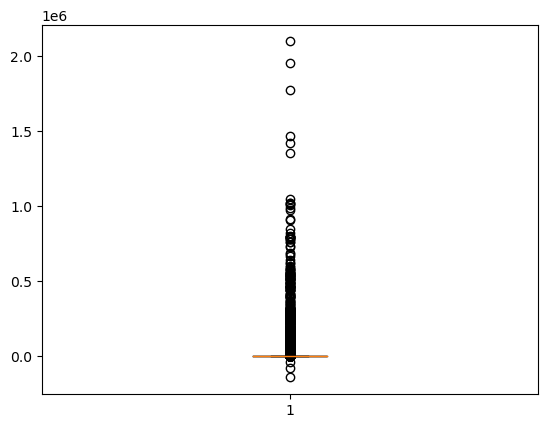

In [14]:
plt.boxplot(data['frete'])
plt.show()

In [15]:
from scipy.stats import zscore

# Calculate z-scores for a column
z_scores = zscore(data['frete'])

# Identify outliers based on a threshold
outlier_threshold = 3
outliers = data[abs(z_scores) > outlier_threshold]

print(outliers)
#create a list with outliers


               jobno                                   custname    jobdate  \
1       JNBIL2301115         SPEEDLINK PROJECTS & TRADE PVT LTD 2033-05-06   
34      MPMSI2300253                                  MEDIMPORT 2023-05-07   
58     HSIVXE2300323                        ELOY NEVES & FILHOS 2023-06-24   
59      RAISI2300097            SICOR EMP.COMERCIAIS E SERVICOS 2023-06-24   
60      VXESI2300074         SITA- SOC.INDUSTRIAL DE TINTAS,LDA 2023-06-24   
...              ...                                        ...        ...   
49590  HSIVXE2200869            SICOR EMP.COMERCIAIS E SERVICOS 2022-12-18   
49595  HSIVXE2200871  RANGEL LOGISTICA CABO VERDE LDA (MINDELO) 2022-12-18   
49602  HSIVXE2200870                        ELOY NEVES & FILHOS 2022-12-18   
49610  HSIVXE2200893                ZEFERINO ROCHA CID UNIP.LDA 2022-12-18   
49670   VXESI2200136                             WATER SOLUTION 2022-12-17   

      biztype departure_loc      destino      frete incoterm  \

## ----------------------------------------------------------

## Tragets and Inputs Variables


In [16]:
#columns = year, month, frete, jobno

#forecasting for the next 3 months
forecast_dist = 3

# Input features (X)
#input_indices=[0,1,3]
inputs = array_3d[:,:-forecast_dist,: ] #last 'forecast_dist' months not included

# Target variable (y)
targets = array_3d[:,forecast_dist:,2]
targets= np.expand_dims(targets, axis= -1) #first 'forecast_dist' months not included

inputs.shape, targets.shape

((2632, 57, 4), (2632, 57, 1))

## Train-Test Split (scikit-learn library)

In [43]:
# Inputs split
inputs_train = array_3d[:, :24, :]  # First 24 months for training
inputs_test = array_3d[:, :27, :]  # First 27 months for testing
inputs_val = array_3d[:, :30, :]   # First 30 months for validation

# Targets split

targets_train = targets[:, :24, :]  # First 24 months for training
targets_test = targets[:, :27, :]  # First 27 months for testing
targets_val = targets[:, :30, :]   # First 30 months for validation


# Check the shapes of the training, testing, and validation sets
print(f"Training shape: {inputs_train.shape} and {targets_train.shape}")
print(f"Testing shape: {inputs_test.shape} and {targets_test.shape}")
print(f"Validation shape: {inputs_val.shape} and {targets_val.shape}")

Training shape: (2632, 24, 4) and (2632, 24, 1)
Testing shape: (2632, 27, 4) and (2632, 27, 1)
Validation shape: (2632, 30, 4) and (2632, 30, 1)


## Definir e treinar o modelo RNN (nao conluído)

In [75]:
#Set all the required Variables 
timesteps = None
features = 4
units_RNN = 32

num_epochs = 10
batch_size = 64

In [69]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()

model.add(LSTM(units=units_RNN, input_shape=(timesteps, features), return_sequences=True)) #n sabemos quantos meses vai receber
#returnsequences faz reparar na sequencia

model.add(LSTM(units=units_RNN, return_sequences=True))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 32)          4736      
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          8320      
                                                                 
 dense_2 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [70]:
class LastThreeMonthsCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, timesteps_per_month):
        super(LastThreeMonthsCallback, self).__init__()
        self.validation_data = validation_data
        self.timesteps_per_month = timesteps_per_month

    def on_epoch_end(self, epoch, logs=None):
        last_three_months_predictions = self.model.predict(self.validation_data[0][:, -3*self.timesteps_per_month:, :])
        last_three_months_targets = self.validation_data[1][:, -3*self.timesteps_per_month:, :]
        val_loss = self.model.evaluate(last_three_months_predictions, last_three_months_targets, verbose=0)
        print("Validation loss for last three months (per dimension): {:.6f}".format(val_loss))

timesteps_per_month = 1
callback = LastThreeMonthsCallback(validation_data=(inputs_test, targets_test), timesteps_per_month=timesteps_per_month)


In [72]:
model.fit(inputs_train, targets_train, validation_data=(inputs_test, targets_test), epochs=num_epochs, batch_size=batch_size, callbacks=None)

Epoch 1/10
42/42 [==============================] - 1s 33ms/step - loss: 7.6175e-07 - val_loss: 7.5138e-05
Epoch 2/10
42/42 [==============================] - 1s 32ms/step - loss: 2.7424e-07 - val_loss: 7.0823e-05
Epoch 3/10
42/42 [==============================] - 1s 33ms/step - loss: 4.5608e-07 - val_loss: 7.1700e-05
Epoch 4/10
42/42 [==============================] - 2s 37ms/step - loss: 1.1764e-07 - val_loss: 6.7215e-05
Epoch 5/10
42/42 [==============================] - 2s 42ms/step - loss: 7.4149e-08 - val_loss: 6.5741e-05
Epoch 6/10
42/42 [==============================] - 1s 34ms/step - loss: 3.9739e-08 - val_loss: 6.7671e-05
Epoch 7/10
42/42 [==============================] - 1s 31ms/step - loss: 3.7416e-08 - val_loss: 6.5084e-05
Epoch 8/10
42/42 [==============================] - 1s 35ms/step - loss: 2.5025e-08 - val_loss: 6.4838e-05
Epoch 9/10
42/42 [==============================] - 1s 34ms/step - loss: 2.0628e-08 - val_loss: 6.4829e-05
Epoch 10/10
42/42 [==================

In [74]:
model.predict(inputs_test[2000])

TypeError: in user code:

    File "C:\Users\guilherme.salvador\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\guilherme.salvador\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\guilherme.salvador\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\guilherme.salvador\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\guilherme.salvador\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\guilherme.salvador\AppData\Roaming\Python\Python39\site-packages\keras\layers\rnn\lstm.py", line 615, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_4' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_4' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


# Callback
    Callbacks in TensorFlow allow you to perform certain actions during training at specific points, such as at the start or end of an epoch, before or after a batch, or when a certain performance threshold is reached. 


In [22]:
preds = model(inputs_train)

In [23]:
preds.shape

TensorShape([2105, 57, 1])

In [24]:
k = 3

In [25]:
aux_preds = preds[:,-k:] # avaliar apenas os últimos 3 meses
aux_targets = targets_train[:,-k:]

In [26]:
aux_targets.shape

(2105, 3, 1)

In [27]:
import tensorflow as tf
mse = tf.keras.losses.MeanSquaredError()

In [28]:
mse(aux_targets, aux_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

## ----------------------------------------------